### Analyze the music21 Bach chorale's repository

In [1]:
%load_ext autoreload
%autoreload 2

from music21 import corpus
from tqdm import tqdm
import utils as u
import pandas as pd
import os
import music21




In [2]:
MIDI_PATH = './data/midi'

In [3]:
chorales_iterator = corpus.chorales.Iterator()
results = list()
for i in tqdm(chorales_iterator):
    i =  i.parts[0]
    results.append(u.analyze_stream(i))

results_chorales_df = pd.json_normalize(results)
results_chorales_df['label'] = 'Chorales'

  0%|          | 0/371 [00:00<?, ?it/s]

100%|██████████| 371/371 [00:26<00:00, 13.86it/s]


In [4]:
results_chants_df = pd.DataFrame()
results = list()
for root, dirs, files in os.walk(MIDI_PATH):
    for file in files:
        if file.endswith('.MID'):
            midi_file = os.path.join(root, file)
            midi_stream = music21.converter.parse(midi_file)
            if len(midi_stream.parts) > 1:
                continue
            i = midi_stream.parts[0]
            results.append(u.analyze_stream(i))
results_chants_df = pd.json_normalize(results)

results_chants_df['label'] = 'Chants'
results_df = pd.concat([results_chorales_df, results_chants_df], ignore_index=True)


In [5]:
display(results_df)

,mean_interval,unique_notes_per_bar,accidentals,syncopations,unique_durations,notes_per_bar,time_signature,label
0,2.044444,1.952381,0.000000,0.190476,2.000000,2.190476,3/4,Chorales
1,2.192308,3.153846,0.153846,0.153846,1.538462,4.076923,4/4,Chorales
2,1.869565,4.000000,0.300000,0.300000,1.700000,4.700000,4/4,Chorales
3,1.976190,3.300000,0.200000,0.200000,1.300000,4.300000,4/4,Chorales
4,1.857143,3.764706,0.058824,0.294118,1.705882,4.588235,4/4,Chorales
...,...,...,...,...,...,...,...,...
377,1.857143,3.375000,0.000000,0.625000,2.125000,4.500000,4/4,Chants
378,1.575758,2.888889,0.000000,0.777778,2.666667,3.777778,4/4,Chants
379,1.666667,2.666667,0.000000,0.333333,2.333333,3.666667,4/4,Chants
380,3.130435,1.777778,0.000000,0.222222,1.777778,2.666667,4/4,Chants


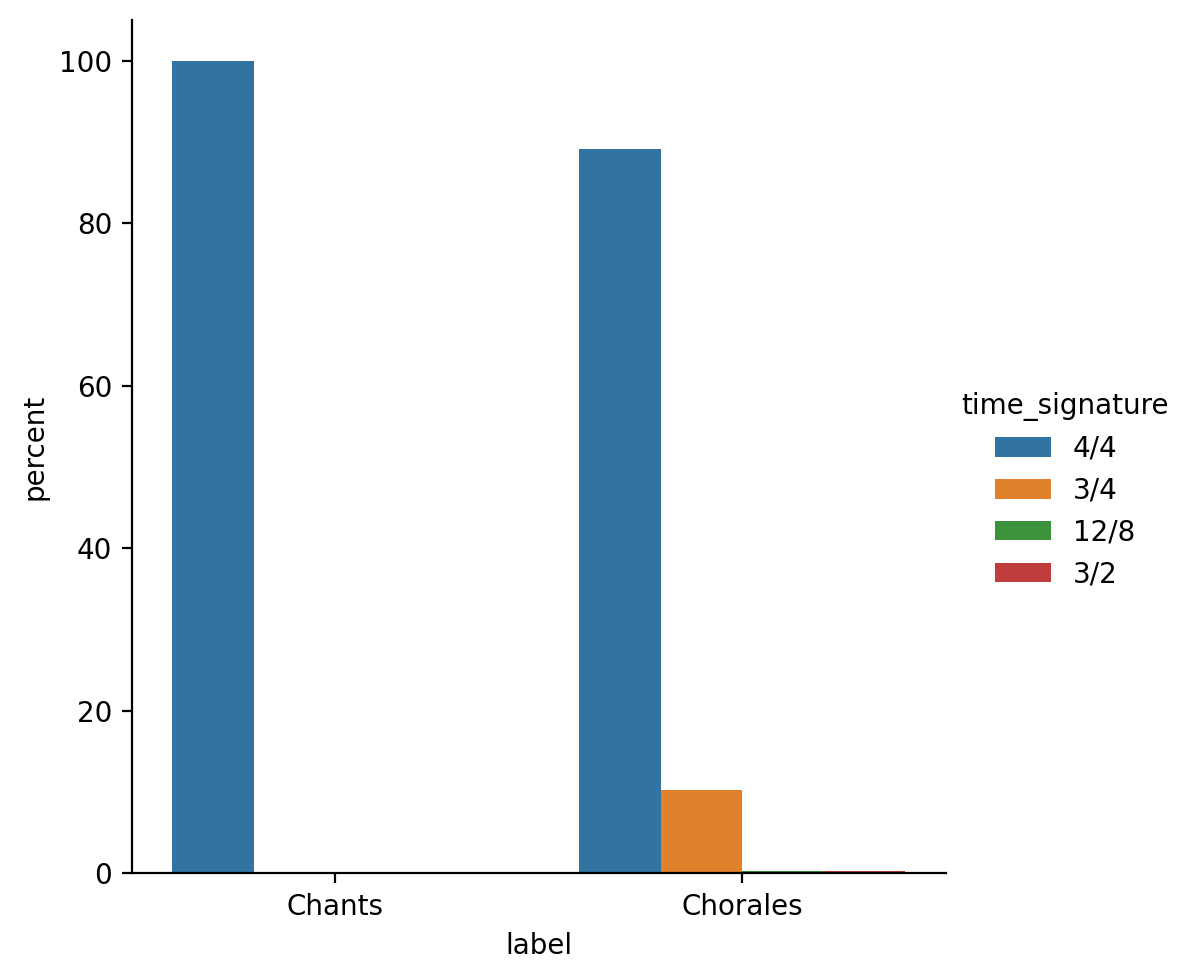

In [7]:
import seaborn as sns
x,y = 'label', 'time_signature'

(results_df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

In [8]:
pd.crosstab(results_df["time_signature"], results_df["label"])

label,Chants,Chorales
time_signature,,
12/8,0,1
3/2,0,1
3/4,0,38
4/4,11,330


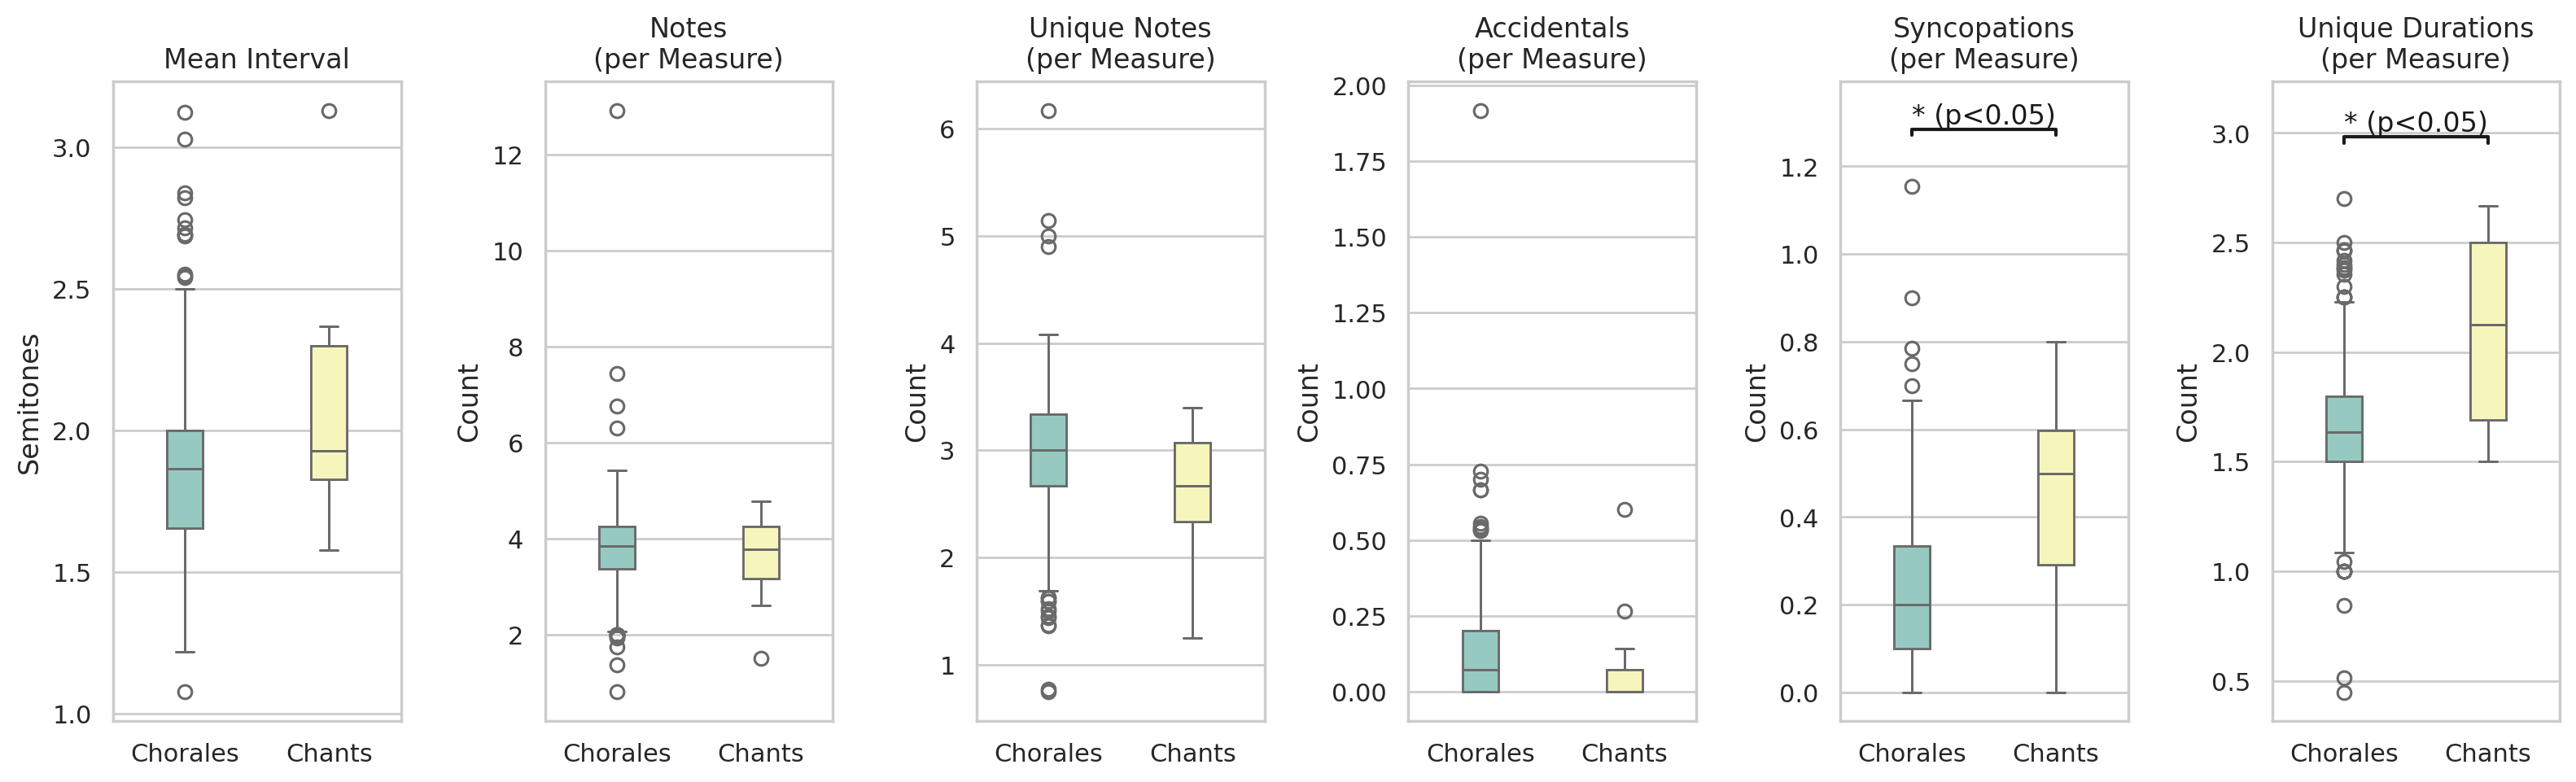

In [55]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

sns.set(style="whitegrid")
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(16, 5))
plt.subplots_adjust(wspace=0.3)



metrics = ['mean_interval', 'notes_per_bar', 'unique_notes_per_bar', 
          'accidentals', 'syncopations', 'unique_durations']

names = ['Mean Interval', 'Notes\n(per Measure)', 'Unique Notes\n(per Measure)', 'Accidentals\n(per Measure)', 'Syncopations\n(per Measure)', 'Unique Durations\n(per Measure)']

ylabels = ['Semitones', 'Count', 'Count', 'Count', 'Count', 'Count']

# Drop nans in the metrics to avoid errors
results_df.dropna(subset=metrics, inplace=True)

for ax, metric, name, ylabel in zip(axes, metrics, names, ylabels):
    sns.boxplot(data=results_df, y=metric, x="label", hue="label", ax=ax, gap=0.5, width=0.5, legend=False, palette="Set3")
    
    # Copute Mann-Whitney U test
    groups = results_df.groupby("label")[metric].apply(list)
    W, p = mannwhitneyu(*groups)

    # Add significance annotation
    y_offset = ax.get_ylim()[1]/20
    u.add_stat_significance(ax, [(0, 1)], [p], y_offset=y_offset, y_increment=y_offset, h=y_offset/5)
    sns.boxplot(data=results_df, y=metric, x="label", hue="label", ax=ax, gap=0.5, width=0.5, legend=False, palette="Set3")


    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    ax.set_title(name)
    plt.tight_layout()

plt.show()


In [15]:
table = list()
for metric, name in zip(metrics, names):
    groups = results_df.groupby("label")[metric].apply(list)
    W, p = mannwhitneyu(*groups)

    table.append({
        "Metric": name,
        "Chants": f"{np.median(groups[0]):.3f}",
        "Chorales": f"{np.median(groups[1]):.3f}",
        "Difference": f"{np.median(groups[0]) - np.median(groups[1]):.3f}",
        "W": f"{W:.1f}",
        "p-value": f"{p:.4f}",
    })

pd.DataFrame(table).to_csv('statistics.csv', index=False)
pd.DataFrame(table).to_latex('statistics.tex', index=False, escape=False, float_format="%.3f", column_format='lcccccc')


/tmp/ipykernel_116095/1542122502.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Chants": f"{np.median(groups[0]):.3f}",
/tmp/ipykernel_116095/1542122502.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Chorales": f"{np.median(groups[1]):.3f}",
/tmp/ipykernel_116095/1542122502.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Difference": f"{np.median(groups[0]) - np.median(groups[1]):.3f}",
/tmp/ipykernel_116095/154212

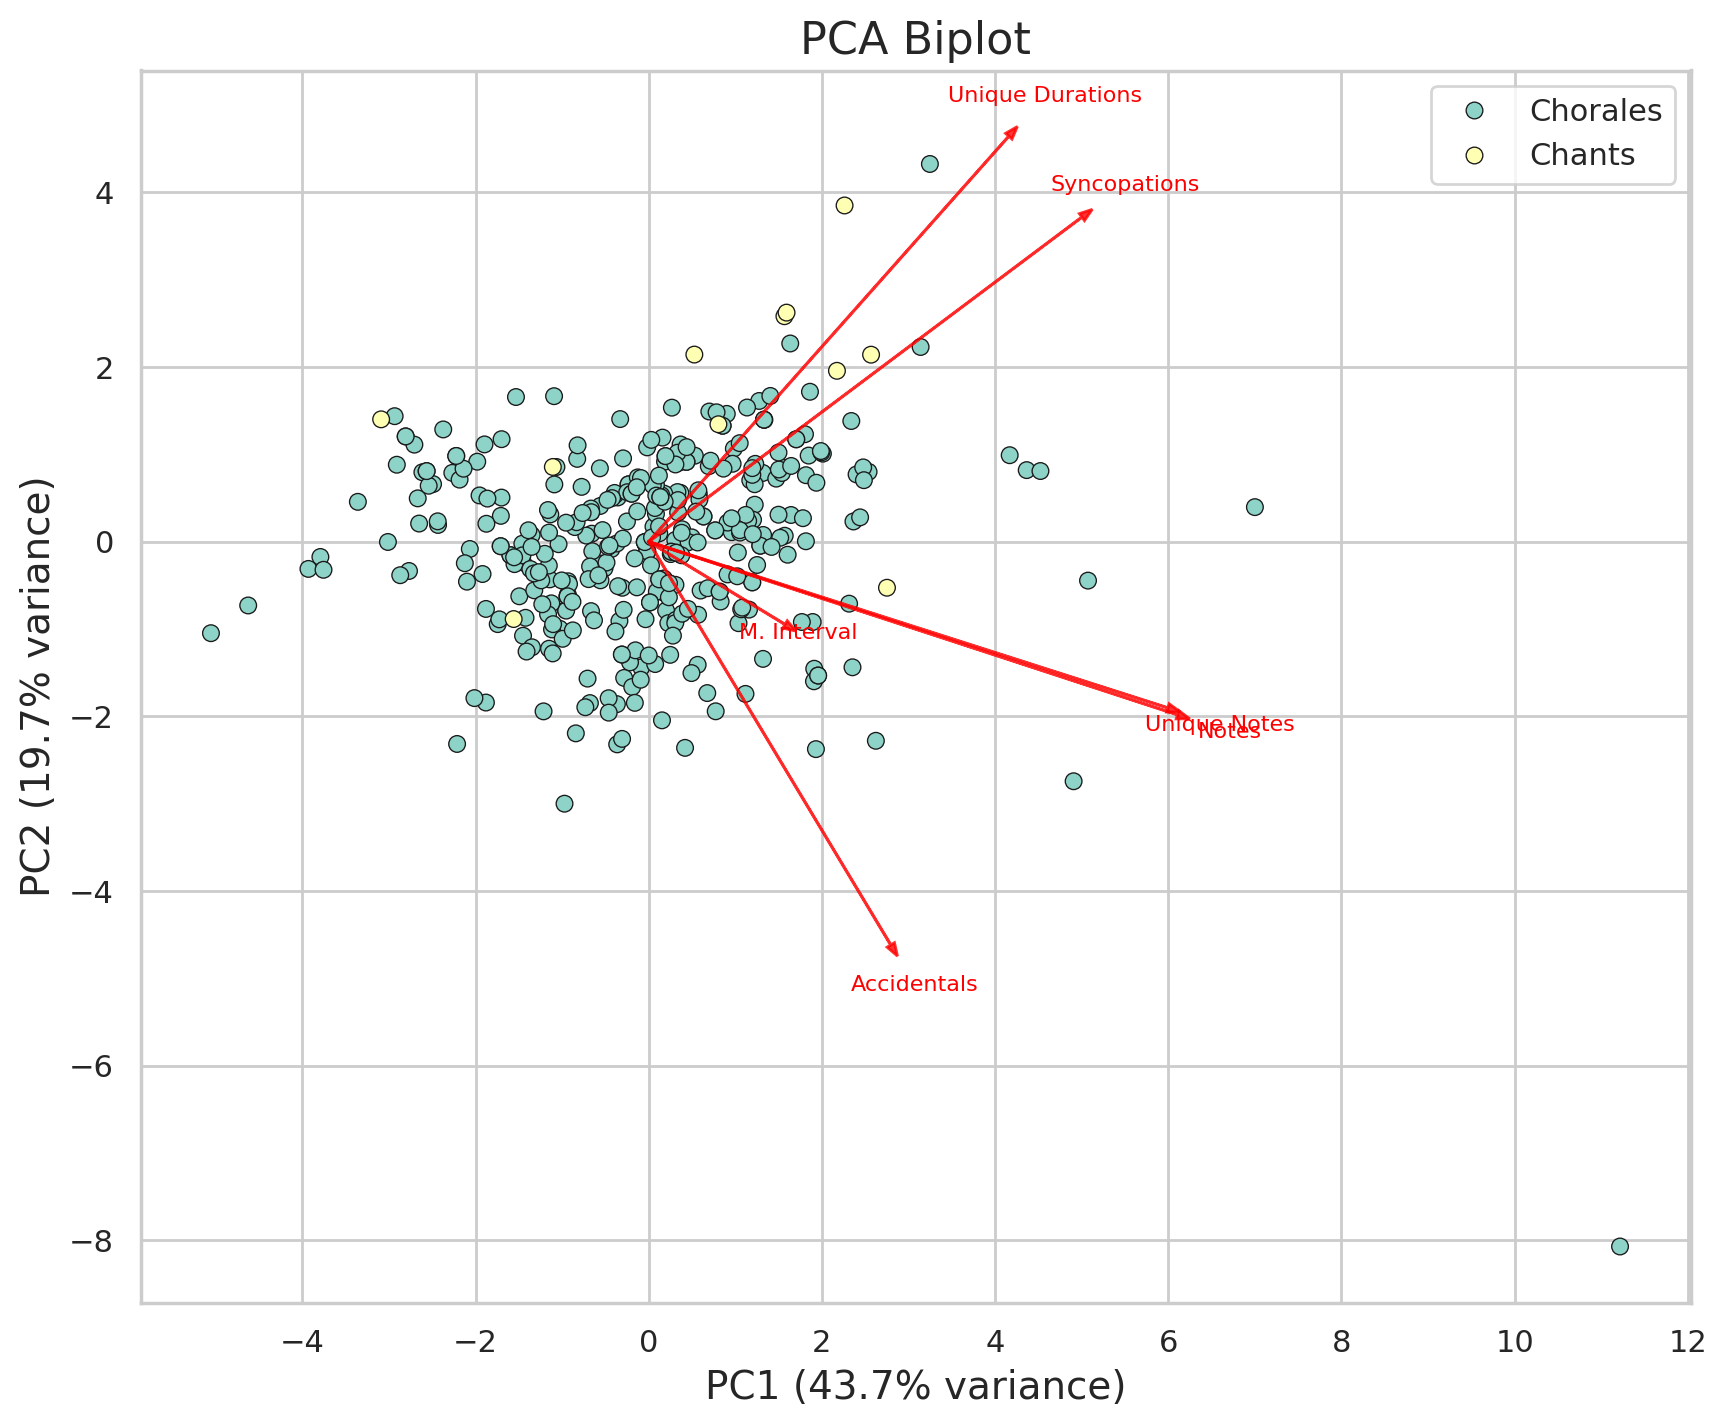

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = results_df[metrics].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)  
scores = pca.fit_transform(X_scaled)
loadings = pca.components_.T

plt.figure(figsize=(10, 8))

# Data points
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=results_df["label"], palette='Set3', edgecolor='k')

# Scale by the maximum absolute value in each PC score.
scale_x = max(np.abs(scores[:, 0]))
scale_y = max(np.abs(scores[:, 1]))

names = ['M. Interval', 
'Notes', 
'Unique Notes', 
'Accidentals', 
'Syncopations', 
'Unique Durations']

# Feature loadings
for i, (metric, name) in enumerate(zip(metrics, names)):

    plt.arrow(0, 0,
              loadings[i, 0] * scale_x,
              loadings[i, 1] * scale_y,
              color='red', width=0.005, head_width=0.1, alpha=0.8)
    plt.text(loadings[i, 0] * scale_x * 1.1,
             loadings[i, 1] * scale_y * 1.1,
             name, color='red', ha='center', va='center', fontsize=8)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=14)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=14)
plt.title("PCA Biplot", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()